# Find population of a US CITY based on
    
    ALAND
    AWATER
    LAT
    LONG
    STATE
    UAtype

https://www.census.gov/geo/maps-data/data/gazetteer2010.html

steps to train a DNN
1. Prepare data
_ clean data
_ vectorize/encode data
_ split data in train,validation and test data
2. Train model
_ create model and layers
_ compile mode(optimizer , metrics, loss)
_ fit model(train data, validation data, epochs, mini batch size)
3. Validate model
_ validate on test data
4. Repeat


In [1]:
import pandas as pd
import numpy as np


In [2]:
#prepare data
city_data = []
#00037	Abbeville, LA Urban Cluster	C	19824	8460	29222871	300497	      11.283	       0.116	 29.967602	 -92.098219  
def parseline(line):
    parts = line.split('\t')
    data={}
    namepart = parts[1].split(',')
    data['NAME']=namepart[0]
    data['STATE']=namepart[1].strip().split()[0].strip()
    data['UAtype']=parts[2]
    data['POP10']= int(parts[3])
    data['ALAND']= int(parts[5])
    data['AWATER']= int(parts[6])
    data['LAT']=float(parts[9])
    data['LONG']=float(parts[10])
    return data
with open('Gaz_ua_national.txt','r') as file:
    city_data = [ parseline(line.strip()) for line in file.readlines()[1:]]

In [3]:
city_data[-1]

{'NAME': 'Zuni Pueblo',
 'STATE': 'NM',
 'UAtype': 'C',
 'POP10': 6744,
 'ALAND': 11876813,
 'AWATER': 0,
 'LAT': 35.071062,
 'LONG': -108.823725}

In [4]:
len(city_data)

3592

In [142]:
df = pd.DataFrame(city_data)
df = df.sample(len(df))#shuffle
df.head()

,ALAND,AWATER,LAT,LONG,NAME,POP10,STATE,UAtype
433,10064941,27207,30.747376,-98.239011,Burnet,5428,TX,C
782,10302907,0,31.982557,-90.356623,Crystal Springs,5269,MS,C
1914,5450600,13259,38.884861,-82.965121,Lucasville,2931,OH,C
2015,15405602,55484,36.841814,-81.502532,Marion,7960,VA,C
240,21487586,27832,26.684083,-80.678914,Belle Glade,24870,FL,C


In [143]:
def to_numerical(labels):
    numerical_dict={}
    for label in labels:
        if label not in numerical_dict:
            numerical_dict[label]=len(numerical_dict)
    return numerical_dict

def to_one_hot(labels):
    numerical = to_numerical(labels)
    one_hot = np.zeros((len(labels),len(numerical)))
    for i,label in enumerate(labels):
        one_hot[i,numerical[label]]=1
    return np.asarray(one_hot)

In [144]:
#normalise data
train, test = (0.8,0.2)
numeric_data = np.asarray(df[['ALAND','AWATER','LAT','LONG']].values)
print(numeric_data[0])
mean=[]
std=[]
def normalize_data(numeric_data,fraction):
    global mean, std
    train_size = int(len(numeric_data)*fraction)
    mean =  numeric_data[:train_size].mean(axis=0)
    std =  numeric_data[:train_size].std(axis=0)
    return (numeric_data - mean)/std
 
numeric_data = normalize_data(numeric_data,train)


[ 1.0064941e+07  2.7207000e+04  3.0747376e+01 -9.8239011e+01]


In [145]:
#encode data
states = to_one_hot(df['STATE'].values)
UA = to_one_hot(df['UAtype'].values)
numeric_data = np.concatenate((numeric_data,states,UA),axis=1)
#merge all data
population = np.asarray(df['POP10'].values).astype(np.float32)/1000#population in thousands
population = population.reshape(len(population),1)
population.min()

2.5

In [146]:
numeric_data.shape

(3592, 158)

In [147]:
#split data

train_f, test_f = (0.8,0.2)
train = int(train_f*len(numeric_data))
x_train_all,x_test = (numeric_data[:train],numeric_data[train:])
y_train_all,y_test = (population[:train],population[train:])


print(x_train_all.shape)
folds = 5
sample_per_fold = train//folds #integer division
print ('Samples per fold = {0}, Number of folds= {1}'.format(sample_per_fold,folds))



(2873, 158)
Samples per fold = 574, Number of folds= 5


In [148]:
from keras import Sequential
from keras import layers
from keras import models
from keras import losses
from keras import optimizers
from keras import metrics

def createmodel(nodes):
    model = Sequential()
    model.add(layers.Dense(nodes[0],activation='relu',input_shape=(x_train.shape[1],)))
    for layer in range(len(nodes)-1):
        model.add(layers.Dense(nodes[layer+1],activation='relu'))
    model.add(layers.Dense(1))#relu activation to avoid negetives produces bad results here
    
    model.compile(optimizer='rmsprop',loss=['mape'],metrics=['mae'])
    return model

In [149]:
all_train_mae = []
all_val_mae = []
import matplotlib.pyplot as pp
%matplotlib inline
def runkfold(l):
    global all_train_mae
    global all_val_mae
    all_train_mae = []
    all_val_mae = []
    for i in range(folds):
        print ('Processing fold # ',i)
        x_validate = x_train_all[i*sample_per_fold : (i+1)*sample_per_fold]
        y_validate = y_train_all[i*sample_per_fold : (i+1)*sample_per_fold]

        x_train = np.concatenate([x_train_all[:i*sample_per_fold],
                                x_train_all[(i+1)*sample_per_fold:]])
        y_train = np.concatenate([y_train_all[:i*sample_per_fold],
                                y_train_all[(i+1)*sample_per_fold:]])
        model = createmodel(l)
        history = model.fit(x_train,y_train,
             validation_data=(x_validate,y_validate),
             epochs=150,
             batch_size = 50,verbose=0)
        all_train_mae.append(history.history['mean_absolute_error'])
        all_val_mae.append(history.history['val_mean_absolute_error'])
        


In [150]:
def ploterrors():
    pp.figure()
    train_mae = np.asarray(all_train_mae).mean(axis=0)
    val_mae = np.asarray(all_val_mae).mean(axis=0)
    pp.plot(train_mae,label='train mae')
    pp.plot(val_mae,label='val mae all')

    for i in range(folds):
        pp.plot(all_val_mae[i],label='val mae ' + str(i),alpha=0.3)
    pp.xlabel('epochs')
    pp.ylabel('mae')
    pp.legend()


[64]
Processing fold #  0
Processing fold #  1
Processing fold #  2
Processing fold #  3
Processing fold #  4


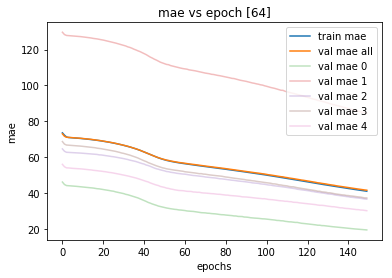

[64, 32]
Processing fold #  0
Processing fold #  1
Processing fold #  2
Processing fold #  3
Processing fold #  4


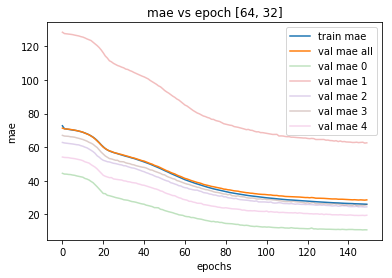

[64, 32, 16]
Processing fold #  0
Processing fold #  1
Processing fold #  2
Processing fold #  3
Processing fold #  4


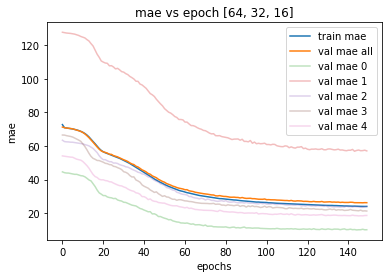

[32, 16, 16, 8]
Processing fold #  0
Processing fold #  1
Processing fold #  2
Processing fold #  3
Processing fold #  4


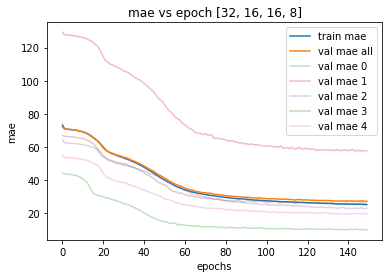

In [151]:
layers_all = [[64],[64,32],[64,32,16],[32,16,16,8]]
for layer in layers_all:
    print (layer)
    runkfold(layer)
    ploterrors()
    pp.title('mae vs epoch {}'.format( layer))
    pp.show()


In [152]:
#[64,32,16] is the best layer combinaiton

model = createmodel([64, 32, 16])
history = model.fit(x_train_all,y_train_all,
             epochs=150,
             batch_size = 50, verbose=0)
#evaluate
model.evaluate(x_test,y_test)

719/719 [==============================] - 2s 3ms/step


[25.504961204794085, 16.65684126481227]

In [153]:
def seepredictions(model):
    df_test = df.loc[df.index[train:]].copy()
    #df.tail(len(df)-train).head(validation) #this should work too
    pred = model.predict(x_test)*1000
    df_test['Predictions']=pred
    df_test['ErrorPercentage']=abs(df_test['Predictions']-df_test['POP10'])/df_test['POP10']*100
    return df_test

In [178]:
print('mean percentage diff = ', seepredictions(model)['ErrorPercentage'].mean())
test_df = seepredictions(model)
print ('Out of {} test data, {} are fluctuating by more than 100%'.format(len(test_df),len(test_df[test_df['ErrorPercentage']>100].index)))

mean percentage diff =  25.504960991256155
Out of 719 test data, 5 are fluctuating by more than 100%


In [185]:
test_df[test_df['POP10']>100000].sample(5)

,ALAND,AWATER,LAT,LONG,NAME,POP10,STATE,UAtype,Predictions,ErrorPercentage
1761,641094177,7665597,40.099901,-76.315150,Lancaster,402004,PA,U,467719.37500,16.346946
2735,1274710664,22584241,37.477942,-77.487983,Richmond,953556,VA,U,974077.37500,2.152089
992,648975307,3375341,31.780239,-106.389031,El Paso,803086,TX--NM,U,403284.75000,49.783118
2820,1219827292,12813910,38.638578,-121.324669,Sacramento,1723634,CA,U,975469.68750,43.406217
2133,576933846,9972885,30.667393,-88.163449,Mobile,326183,AL,U,372524.90625,14.207333


In [186]:
test_df[test_df['POP10']<5000].sample(5)

,ALAND,AWATER,LAT,LONG,NAME,POP10,STATE,UAtype,Predictions,ErrorPercentage
1317,11817615,529671,38.498966,-122.997327,Guerneville,4805,CA,C,3990.423828,16.952678
3451,4809551,4692,37.550722,-76.812980,West Point,2675,VA,C,3410.743652,27.504436
2282,3388284,0,38.538515,-89.696976,New Baden,3424,IL,C,2679.464355,21.744616
37,7434016,56074,41.890344,-80.355166,Albion,4574,PA,C,3775.866943,17.449345
2465,13770881,866486,37.270814,-107.071991,Pagosa Springs,4909,CO,C,5489.715332,11.829605
